<a href="https://colab.research.google.com/github/Habibmaryam/Election-outlier-detection/blob/main/Outlier_detection_analysis_by_Maryam_Habib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### IMPORTING LIBRARIES

In [ ]:
!pip install geopy
!pip install folium
!pip install scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import folium
import requests
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import haversine_distances
from geopy.distance import geodesic
from scipy.stats import zscore
from folium.plugins import MarkerCluster

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load the main dataset and the dataset with lat/lon information

In [ ]:
main_df = pd.read_csv('/content/drive/MyDrive/Sokoto Crosschecked - SOKOTO_crosschecked.csv')
#lat_lon_df = pd.read_csv('polling-units.csv')

# Merge the datasets on the common column (Ward)
#df = pd.merge(main_df, lat_lon_df, on='Ward')

# check the first 5 rows of the data
print(main_df.head())

    State   Latitude  Longitude      LGA             Ward       PU-Code  \
0  SOKOTO  13.183385   4.987049    BINJI           INNAME  33-01-01-002   
1  SOKOTO  13.154333   5.002645    BINJI           SAMAMA  33-01-02-001   
2  SOKOTO  13.222221   4.911728    BINJI            BINJI  33-01-03-002   
3  SOKOTO  12.879571   5.242388  BODINGA         BAGARAWA  33-02-02-003   
4  SOKOTO  12.973935   5.128989  BODINGA  DINGYADI/BADAWA  33-02-06-015   

              PU-Name                                       Full Address  \
0      GURUZA /SAMAMA   SOKOTO BINJI INNAME 33-01-01-002 GURUZA /SAMAMA    
1       SAMAMA MARINA    SOKOTO BINJI SAMAMA 33-01-02-001 SAMAMA MARINA    
2            BAJAGAWA          SOKOTO BINJI BINJI 33-01-03-002 BAJAGAWA    
3    PRY SCH, R/YARDE  SOKOTO BODINGA BAGARAWA 33-02-02-003 PRY SCH, ...   
4  DANFILI,RUNJI AUDU  SOKOTO BODINGA DINGYADI/BADAWA 33-02-06-015 DA...   

   Accredited_Voters  Registered_Voters  ...  Result_Sheet_Stamped  \
0                261  

In [ ]:
# Check the merging result
print("DataFrame shape:", main_df.shape)
print(main_df.head())

DataFrame shape: (132, 22)
    State   Latitude  Longitude      LGA             Ward       PU-Code  \
0  SOKOTO  13.183385   4.987049    BINJI           INNAME  33-01-01-002   
1  SOKOTO  13.154333   5.002645    BINJI           SAMAMA  33-01-02-001   
2  SOKOTO  13.222221   4.911728    BINJI            BINJI  33-01-03-002   
3  SOKOTO  12.879571   5.242388  BODINGA         BAGARAWA  33-02-02-003   
4  SOKOTO  12.973935   5.128989  BODINGA  DINGYADI/BADAWA  33-02-06-015   

              PU-Name                                       Full Address  \
0      GURUZA /SAMAMA   SOKOTO BINJI INNAME 33-01-01-002 GURUZA /SAMAMA    
1       SAMAMA MARINA    SOKOTO BINJI SAMAMA 33-01-02-001 SAMAMA MARINA    
2            BAJAGAWA          SOKOTO BINJI BINJI 33-01-03-002 BAJAGAWA    
3    PRY SCH, R/YARDE  SOKOTO BODINGA BAGARAWA 33-02-02-003 PRY SCH, ...   
4  DANFILI,RUNJI AUDU  SOKOTO BODINGA DINGYADI/BADAWA 33-02-06-015 DA...   

   Accredited_Voters  Registered_Voters  ...  Result_Sheet_Stampe

In [ ]:
# Check for missing values in 'latitude' and 'longitude' columns
print(main_df[['Latitude', 'Longitude']].isnull().sum())

Latitude     1
Longitude    1
dtype: int64


### Drop NaN Values

In [ ]:
# Drop rows with missing values in 'latitude' and 'longitude' columns
df = main_df.dropna(subset=['Latitude', 'Longitude'])

# Ensure DataFrame is not empty after dropping missing values
if main_df.empty:
    raise ValueError("DataFrame is empty after handling missing values. Check the merging process and data integrity.")

# Convert latitudes and longitudes to radians

In [ ]:
main_df['Latitude_radians'] = np.radians(df['Latitude'])
main_df['Longitude_radians'] = np.radians(df['Longitude'])

In [ ]:
coords = df[['Latitude_radians', 'Longitude_radians']].values
if coords.size == 0:
    raise ValueError("Coordinates array is empty. Check your data and merging process.")

dist_matrix = haversine_distances(coords) * 6371  # Convert to kilometers
# Define a radius (1 km)
radius = 1

# Extract coordinates from DataFrame
coords = df[['Latitude_radians', 'Longitude_radians']].values

# Check if coordinates array is empty
if coords.size == 0:
    raise ValueError("Coordinates array is empty. Check your data and merging process.")

from sklearn.metrics.pairwise import haversine_distances
dist_matrix = haversine_distances(coords) * 6371  # Convert to kilometers

# Define a radius (1 km)
radius = 1

# Identify neighbors within the radius
neighbors = {i: np.where(dist_matrix[i] <= radius)[0] for i in range(len(df))}

# Identify neighbors within the radius
neighbors = {i: np.where(dist_matrix[i] <= radius)[0] for i in range(len(df))}

In [ ]:
# Create an empty DataFrame for distances
distances = pd.DataFrame(index=main_df.index, columns=main_df.index)

# Calculate pairwise distances
for i in main_df.index:
    for j in main_df.index:
        # Convert single points to a numpy array for the haversine_distances function
        point1 = np.array([main_df.loc[i, 'Latitude_radians'], main_df.loc[i, 'Longitude_radians']]).reshape(1, -1)
        point2 = np.array([main_df.loc[j, 'Latitude_radians'], main_df.loc[j, 'Longitude_radians']]).reshape(1, -1)

        # Calculate the distance and extract the single value
        distance = haversine_distances(point1, point2)[0][0]

        distances.loc[i, j] = distance * 6371  # Earth radius in kilometers

ValueError: Input contains NaN.

In [ ]:
# Convert distances from kilometers to miles
distances = distances.astype(float) * 0.621371

In [ ]:
# Identify neighbors within a certain distance (e.g., 50 miles)
neighbors_within_50_miles = distances < 50

In [ ]:
print("Pairwise distances in miles:")
print(distances)

Pairwise distances in miles:
     0         1         2          3          4          5          6    \
0    0.0  2.264957  5.733298  27.130491  17.340165  19.251622  19.251622   
1    NaN       NaN       NaN        NaN        NaN        NaN        NaN   
2    NaN       NaN       NaN        NaN        NaN        NaN        NaN   
3    NaN       NaN       NaN        NaN        NaN        NaN        NaN   
4    NaN       NaN       NaN        NaN        NaN        NaN        NaN   
..   ...       ...       ...        ...        ...        ...        ...   
127  NaN       NaN       NaN        NaN        NaN        NaN        NaN   
128  NaN       NaN       NaN        NaN        NaN        NaN        NaN   
129  NaN       NaN       NaN        NaN        NaN        NaN        NaN   
130  NaN       NaN       NaN        NaN        NaN        NaN        NaN   
131  NaN       NaN       NaN        NaN        NaN        NaN        NaN   

           7          8         9    ...  122  123  124  1

In [ ]:
print("\nNeighbors within 50 miles:")
print(neighbors_within_50_miles)


Neighbors within 50 miles:
       0      1      2      3      4      5      6      7      8      9    \
0     True   True   True   True   True   True   True   True   True   True   
1    False  False  False  False  False  False  False  False  False  False   
2    False  False  False  False  False  False  False  False  False  False   
3    False  False  False  False  False  False  False  False  False  False   
4    False  False  False  False  False  False  False  False  False  False   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
127  False  False  False  False  False  False  False  False  False  False   
128  False  False  False  False  False  False  False  False  False  False   
129  False  False  False  False  False  False  False  False  False  False   
130  False  False  False  False  False  False  False  False  False  False   
131  False  False  False  False  False  False  False  False  False  False   

     ...    122    123    124    125    126    

### Calculate pairwise distances and identify neighbors

In [ ]:
coords = df[['Latitude_radians', 'Longitude_radians']].values
if coords.size == 0:
    raise ValueError("Coordinates array is empty. Check your data and merging process.")

dist_matrix = haversine_distances(coords) * 6371  # Convert to kilometers

# Define a radius (1 km)
radius = 1

# Identify neighbors within the radius
neighbors = {i: np.where(dist_matrix[i] <= radius)[0] for i in range(len(df))}

# Calculate outlier scores

In [ ]:
def calculate_outlier_scores(neighbors, df, id_column):
    outlier_scores = []
    for i, neighbor_indices in neighbors.items():
        if len(neighbor_indices) > 1:
            for party in ['APC', 'LP', 'PDP', 'NNPP']:
                votes = df.iloc[neighbor_indices][party].values
                z_scores = zscore(votes)
                outlier_scores.append({
                    id_column: df.iloc[i][id_column],
                    'party': party,
                    'outlier_score': z_scores[np.where(neighbor_indices == i)[0][0]]
                })
    return pd.DataFrame(outlier_scores)

# Determine the appropriate identifier column
id_column = 'unit_id' if 'unit_id' in df.columns else df.columns[4]

# Calculate outlier scores
outlier_scores = calculate_outlier_scores(neighbors, df, id_column)
print(outlier_scores.head())

               Ward party  outlier_score
0  TULLUWA/KULAFASA   APC      -0.844871
1  TULLUWA/KULAFASA    LP            NaN
2  TULLUWA/KULAFASA   PDP      -0.217217
3  TULLUWA/KULAFASA  NNPP            NaN
4  TULLUWA/KULAFASA   APC      -0.559727


In [ ]:
# Define a function to calculate the outlier score
def calculate_outlier_score(votes, neighbor_votes):
    return abs(votes - np.mean(neighbor_votes))

# Sample DataFrame
data = {
    'PU-Name': ['PU1', 'PU2', 'PU3', 'PU4'],
    'latitude': [6.5244, 6.5245, 6.5246, 6.5247],
    'longitude': [3.3792, 3.3793, 3.3794, 3.3795],
    'APC': [100, 150, 120, 130],
    'LP': [200, 180, 210, 220],
    'PDP': [300, 280, 290, 310],
    'NNPP': [50, 60, 55, 65]
}
df = pd.DataFrame(data)

# Define a radius (in km)
radius = 1

# Initialize outlier score columns
df['APC_outlier_score'] = 0.0
df['LP_outlier_score'] = 0.0
df['PDP_outlier_score'] = 0.0
df['NNPP_outlier_score'] = 0.0

# Calculate outlier scores for each polling unit
for i, row in df.iterrows():
    # Get the coordinates of the current polling unit
    current_coords = (row['latitude'], row['longitude'])

    # Find neighboring polling units
    neighbors = []
    for j, neighbor_row in df.iterrows():
        if i != j:
            neighbor_coords = (neighbor_row['latitude'], neighbor_row['longitude'])
            distance = geodesic(current_coords, neighbor_coords).kilometers
            if distance <= radius:
                neighbors.append(neighbor_row)

    if neighbors:
        # Calculate outlier scores for each party
        neighbors_df = pd.DataFrame(neighbors)
        df.at[i, 'APC_outlier_score'] = calculate_outlier_score(row['APC'], neighbors_df['APC'])
        df.at[i, 'LP_outlier_score'] = calculate_outlier_score(row['LP'], neighbors_df['LP'])
        df.at[i, 'PDP_outlier_score'] = calculate_outlier_score(row['PDP'], neighbors_df['PDP'])
        df.at[i, 'NNPP_outlier_score'] = calculate_outlier_score(row['NNPP'], neighbors_df['NNPP'])

print(df)

  PU-Name  latitude  longitude  APC   LP  PDP  NNPP  APC_outlier_score  \
0     PU1    6.5244     3.3792  100  200  300    50          33.333333   
1     PU2    6.5245     3.3793  150  180  280    60          33.333333   
2     PU3    6.5246     3.3794  120  210  290    55           6.666667   
3     PU4    6.5247     3.3795  130  220  310    65           6.666667   

   LP_outlier_score  PDP_outlier_score  NNPP_outlier_score  
0          3.333333           6.666667           10.000000  
1         30.000000          20.000000            3.333333  
2         10.000000           6.666667            3.333333  
3         23.333333          20.000000           10.000000  


### Save the cleaned dataset to a CSV file

In [ ]:
cleaned_dataset_filename = 'maryam_sokoto_outlier_scores.csv'
df.to_csv(cleaned_dataset_filename, index=False)

print(f"Cleaned dataset saved to {cleaned_dataset_filename}")

Cleaned dataset saved to maryam_sokoto_outlier_scores.csv


## Visualization

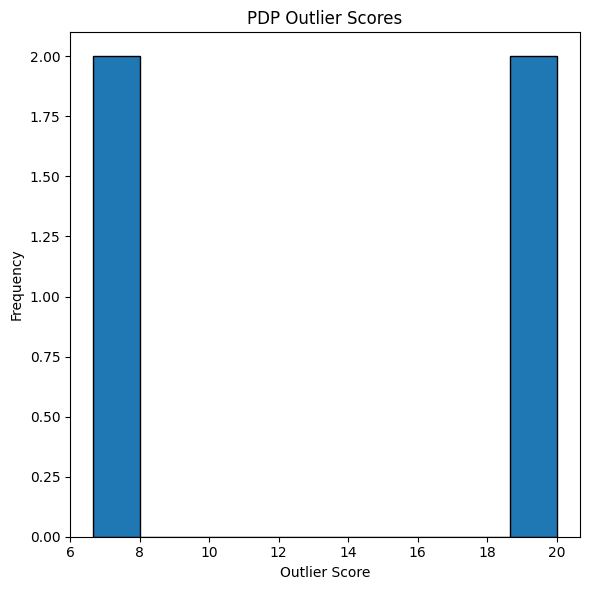

In [ ]:
# Plotting the histogram for PDP outlier scores
plt.figure(figsize=(6, 6))
plt.hist(df['PDP_outlier_score'], bins=10, edgecolor='black')
plt.xlabel('Outlier Score')
plt.ylabel('Frequency')
plt.title('PDP Outlier Scores')
plt.tight_layout()
plt.show()


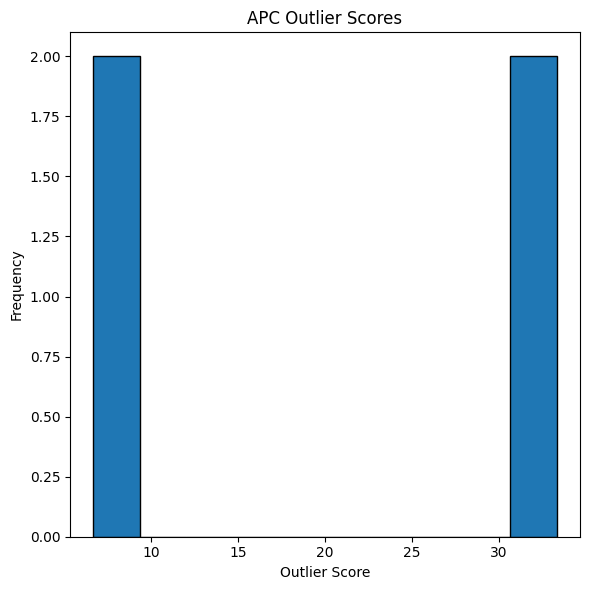

In [ ]:
# Plotting the histogram for PDP outlier scores
plt.figure(figsize=(6, 6))
plt.hist(df['APC_outlier_score'], bins=10, edgecolor='black')
plt.xlabel('Outlier Score')
plt.ylabel('Frequency')
plt.title('APC Outlier Scores')
plt.tight_layout()
plt.show()

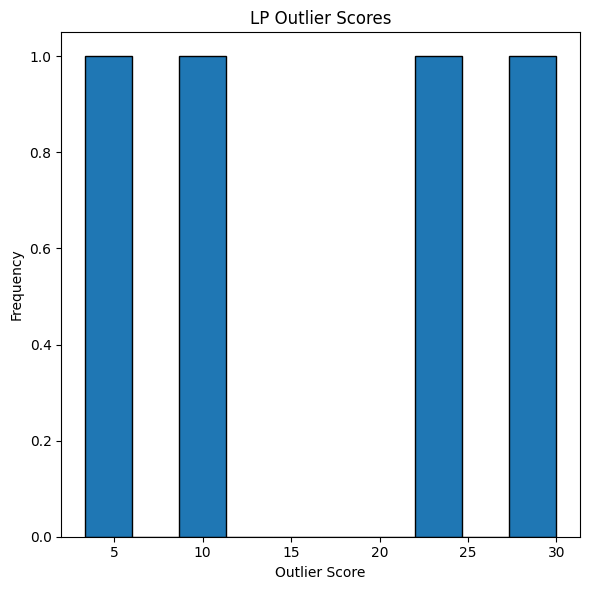

In [ ]:
# Plotting the histogram for PDP outlier scores
plt.figure(figsize=(6, 6))
plt.hist(df['LP_outlier_score'], bins=10, edgecolor='black')
plt.xlabel('Outlier Score')
plt.ylabel('Frequency')
plt.title('LP Outlier Scores')
plt.tight_layout()
plt.show()

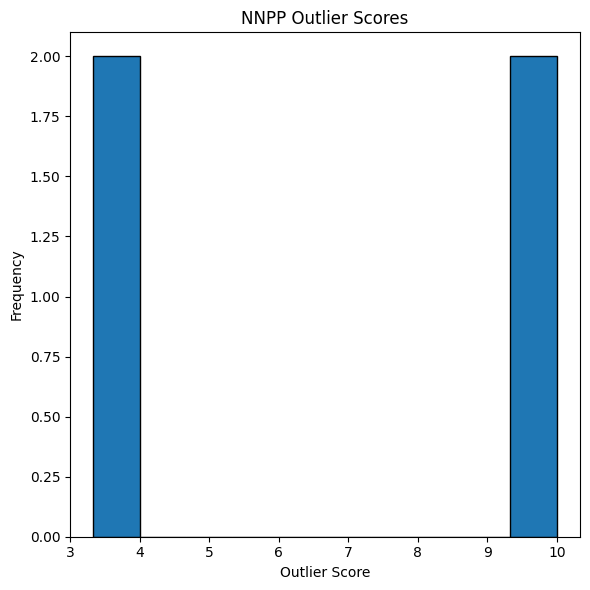

In [ ]:
# Plotting the histogram for PDP outlier scores
plt.figure(figsize=(6, 6))
plt.hist(df['NNPP_outlier_score'], bins=10, edgecolor='black')
plt.xlabel('Outlier Score')
plt.ylabel('Frequency')
plt.title('NNPP Outlier Scores')
plt.tight_layout()
plt.show()

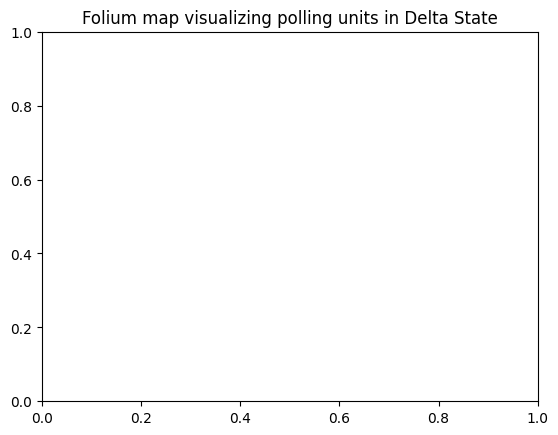

In [ ]:
import folium

# Create a folium map to visualize polling units
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=12)


# Add markers for each polling unit
for index, row in df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Polling Unit: {row['PU-Name']}\nAPC Outlier Score: {row['APC_outlier_score']}\nLP Outlier Score: {row['LP_outlier_score']}\nPDP Outlier Score: {row['PDP_outlier_score']}\nNNPP Outlier Score: {row['NNPP_outlier_score']}"
    ).add_to(m)
plt.title('Folium map visualizing polling units in Delta State')
# Save the map as an HTML file
m.save('polling_units_map.html')

# Display the map (this will work in Jupyter notebooks)
m

In [ ]:
# Save the map as an HTML file
m.save('polling_units_map.html')

# Sort the dataset by outlier scores

In [ ]:
sorted_outliers = outlier_scores.sort_values(by='outlier_score', ascending=False)
sorted_outliers.to_csv('sorted_outlier_scores.csv', index=False)
print(sorted_outliers.head())

               Ward party  outlier_score
197        GAGI 'B'    LP       3.781057
116      T/WADA 'A'   APC       2.190209
74     S/BIRNI WEST   PDP       2.159632
214  DOGONDAJI/SALA   PDP       1.951496
179            TARA  NNPP       1.732051


# Identify top 3 outliers for each party

In [ ]:
top_outliers = sorted_outliers.groupby('party').head(3)
print(top_outliers)

                 Ward party  outlier_score
197          GAGI 'B'    LP       3.781057
116        T/WADA 'A'   APC       2.190209
74       S/BIRNI WEST   PDP       2.159632
214    DOGONDAJI/SALA   PDP       1.951496
179              TARA  NNPP       1.732051
123        T/WADA 'B'  NNPP       1.732051
71       S/BIRNI EAST  NNPP       1.732051
216    DOGONDAJI/SALA   APC       1.544908
21               GADA    LP       1.414214
8    TULLUWA/KULAFASA   APC       1.404599
10   TULLUWA/KULAFASA   PDP       1.318820
109      S/ADAR GANDU    LP       1.000000


In [ ]:
# Explain why they are outliers
for index, row in top_outliers.iterrows():
    identifier = row[id_column]
    party = row['party']
    score = row['outlier_score']
    print(f"Unit {identifier} is an outlier for {party} with an outlier score of {score}.")

Unit GAGI 'B' is an outlier for LP with an outlier score of 3.7810567581342225.
Unit T/WADA 'A' is an outlier for APC with an outlier score of 2.1902086607507565.
Unit S/BIRNI WEST is an outlier for PDP with an outlier score of 2.1596316322278124.
Unit DOGONDAJI/SALA is an outlier for PDP with an outlier score of 1.9514956893517916.
Unit TARA is an outlier for NNPP with an outlier score of 1.7320508075688774.
Unit T/WADA 'B' is an outlier for NNPP with an outlier score of 1.7320508075688774.
Unit S/BIRNI EAST is an outlier for NNPP with an outlier score of 1.7320508075688774.
Unit DOGONDAJI/SALA is an outlier for APC with an outlier score of 1.5449078715223483.
Unit GADA is an outlier for LP with an outlier score of 1.414213562373095.
Unit TULLUWA/KULAFASA is an outlier for APC with an outlier score of 1.4045987374355149.
Unit TULLUWA/KULAFASA is an outlier for PDP with an outlier score of 1.318820470647445.
Unit S/ADAR GANDU is an outlier for LP with an outlier score of 1.0.


In [ ]:
# Save sorted outlier scores to a CSV file
sorted_outliers.to_csv('sorted_outlier_scores.csv', index=False)

In [ ]:
# Identify top 3 outliers for each party
top_outliers = sorted_outliers.groupby('party').head(3)

# Save top outliers to a CSV file
top_outliers.to_csv('top_outliers.csv', index=False)

In [ ]:
# Save the full dataset with calculated columns
df.to_csv('full_dataset_with_calculations.csv', index=False)

In [ ]:
# Print statements to confirm saving
print("Sorted outlier scores saved to 'sorted_outlier_scores.csv'")
print("Top 3 outliers for each party saved to 'top_outliers.csv'")
print("Full dataset with calculations saved to 'full_dataset_with_calculations.csv'")

Sorted outlier scores saved to 'sorted_outlier_scores.csv'
Top 3 outliers for each party saved to 'top_outliers.csv'
Full dataset with calculations saved to 'full_dataset_with_calculations.csv'
